In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from math import log2
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import median_absolute_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
import time
import matplotlib as mpl

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split

import pathlib
import os
import sys

# for selection the right path
import os,sys,inspect,pathlib
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common.model_trainer_reg import *
from common.regression_plotfunctions import *


from GD.LinearRegression import LinearRegression
from KNN.KNNRegressor import KNNRegressor

import metro_preprocessing


In [9]:
# Custom functions

module_path = pathlib.Path(os.getcwd()).parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
print(sys.path)

from common.dataset_grabber import get_data_path

['/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Metro', '', '/home/alexander/ngsuite/ngsolve-install/lib/python3/dist-packages', '/home/alexander/ngsuite/ngsolve-install/bin', '/home/alexander/.local/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.392013122/pythonFiles', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.392013122/pythonFiles/lib/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/home/alexander/.local/lib/python3.7/site-packages', '/usr/local/l

# Train and Test

In [10]:
datapath = get_data_path("Metro", "Metro_Interstate_Traffic_Volume.csv")
display(datapath)

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Datasets/Metro/Metro_Interstate_Traffic_Volume.csv')

In [11]:
df_raw = pd.read_csv(datapath)
df_raw = df_raw.sample(3000)

In [12]:
X, Y = metro_preprocessing.preprocessing(df_raw, transform = True)

## SGD-Regression

In [13]:
MODEL = SGDRegressor
NAME = "SGD"
PATH = "out/"+NAME+"/"
params = {"alpha" : [0.0001]}
n_splits = 2

modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
score_list_SGD = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

('alpha',) ([0.0001],)
Finished evaluation
R2_score= 0.245438808905441
Total evaluation time = 0.17s


,alpha,train_time,inference_time,R2_score,RMSE
0,0.0001,0.002977,0.003953,0.245439,0.773997


('alpha',) ([0.0001],)
Finished evaluation
R2_score= 0.2532968034879247
Total evaluation time = 0.17s


,alpha,train_time,inference_time,R2_score,RMSE
0,0.0001,0.003999,0.003291,0.253297,0.729043


('alpha',) ([0.0001],)
Finished evaluation
R2_score= 0.245438808905441
Total evaluation time = 0.17s
('alpha',) ([0.0001],)
Finished evaluation
R2_score= 0.2532968034879247
Total evaluation time = 0.16s
('alpha',) ([0.0001],)
Finished evaluation
R2_score= 0.2532968034879247
Total evaluation time = 0.17s


,alpha,train_time,inference_time,R2_score,RMSE
0,0.0001,0.003732,0.005507,0.253297,0.729043


In [14]:
MODEL = LinearRegression
params = {"alpha" : [0.00000000001], "max_iter": [1000,10000], "weigths": ["residual"]}


modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
score_list_SGD_own = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

('alpha', 'max_iter', 'weigths') ([1e-11], [1000, 10000], ['residual'])
Finished evaluation
R2_score= -0.046054770530624456
Total evaluation time = 0.37s


,alpha,max_iter,weigths,train_time,inference_time,R2_score,RMSE
0,1.000000e-11,1000,residual,0.040674,0.050109,-0.046133,1.073078
1,1.000000e-11,10000,residual,0.193990,0.027049,-0.046055,1.072998


('alpha', 'max_iter', 'weigths') ([1e-11], [1000, 10000], ['residual'])
Finished evaluation
R2_score= 0.04386145803231167
Total evaluation time = 0.37s


,alpha,max_iter,weigths,train_time,inference_time,R2_score,RMSE
0,1.000000e-11,1000,residual,0.031163,0.040641,0.043856,0.933531
1,1.000000e-11,10000,residual,0.200171,0.027858,0.043861,0.933525


('alpha', 'max_iter', 'weigths') ([1e-11], [1000, 10000], ['residual'])
Finished evaluation
R2_score= -0.046054770530624456
Total evaluation time = 0.36s
('alpha', 'max_iter', 'weigths') ([1e-11], [1000, 10000], ['residual'])
Finished evaluation
R2_score= 0.04386145803231167
Total evaluation time = 0.37s
('alpha', 'max_iter', 'weigths') ([1e-11], [1000, 10000], ['residual'])
Finished evaluation
R2_score= 0.04386145803231167
Total evaluation time = 0.37s


,alpha,max_iter,weigths,train_time,inference_time,R2_score,RMSE
0,1.000000e-11,1000,residual,0.052058,0.029499,0.043856,0.933531
1,1.000000e-11,10000,residual,0.200422,0.030331,0.043861,0.933525


## KNN-Regression

In [15]:
MODEL = KNeighborsRegressor
params = {"weights" : ["uniform"]}
NAME = "KNN"
PATH = "out/"+NAME+"/"


modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
score_list_KNN = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

('weights',) (['uniform'],)
Finished evaluation
R2_score= 0.48297286614596346
Total evaluation time = 0.17s


,weights,train_time,inference_time,R2_score,RMSE
0,uniform,0.008933,0.055192,0.482973,0.530344


('weights',) (['uniform'],)
Finished evaluation
R2_score= 0.49089844242769054
Total evaluation time = 0.16s


,weights,train_time,inference_time,R2_score,RMSE
0,uniform,0.007494,0.037953,0.490898,0.497061


('weights',) (['uniform'],)
Finished evaluation
R2_score= 0.48297286614596346
Total evaluation time = 0.16s
('weights',) (['uniform'],)
Finished evaluation
R2_score= 0.49089844242769054
Total evaluation time = 0.16s
('weights',) (['uniform'],)
Finished evaluation
R2_score= 0.49089844242769054
Total evaluation time = 0.16s


,weights,train_time,inference_time,R2_score,RMSE
0,uniform,0.005312,0.035741,0.490898,0.497061


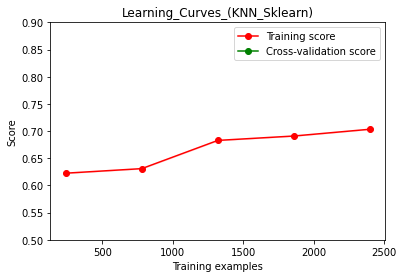

In [16]:
plt.figure()
plt.grid()

title = "Learning_Curves_(KNN_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = KNeighborsRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.5, 0.90), cv=cv, n_jobs=4)
plt.savefig(PATH+title)
plt.show()

In [17]:
MODEL = KNNRegressor
params = {"n_neighbors" : [5],
           "p": [2]}#,
           #'weights': ['uniform']}
NAME = "KNN"
PATH = "out/"+NAME+"/"

modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
score_list_KNN_own = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

('n_neighbors', 'p') ([5], [2])
Finished evaluation
R2_score= 0.48297286614596346
Total evaluation time = 0.38s


,n_neighbors,p,train_time,inference_time,R2_score,RMSE
0,5,2,0.000026,0.232033,0.482973,0.530344


('n_neighbors', 'p') ([5], [2])
Finished evaluation
R2_score= 0.49089844242769054
Total evaluation time = 0.38s


,n_neighbors,p,train_time,inference_time,R2_score,RMSE
0,5,2,0.000015,0.231886,0.490898,0.497061


('n_neighbors', 'p') ([5], [2])
Finished evaluation
R2_score= 0.48297286614596346
Total evaluation time = 0.38s
('n_neighbors', 'p') ([5], [2])
Finished evaluation
R2_score= 0.49089844242769054
Total evaluation time = 0.36s
('n_neighbors', 'p') ([5], [2])
Finished evaluation
R2_score= 0.49089844242769054
Total evaluation time = 0.38s


,n_neighbors,p,train_time,inference_time,R2_score,RMSE
0,5,2,0.000017,0.240114,0.490898,0.497061


## RF-Regression

In [18]:
MODEL = RandomForestRegressor
params = {"n_estimators" : [100]}
NAME = "RF"
PATH = "out/"+NAME+"/"


modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
score_list_RF = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

('n_estimators',) ([100],)
Finished evaluation
R2_score= 0.7901290840074983
Total evaluation time = 0.87s


,n_estimators,train_time,inference_time,R2_score,RMSE
0,100,0.744944,0.026461,0.790129,0.215277


('n_estimators',) ([100],)
Finished evaluation
R2_score= 0.8138858438591559
Total evaluation time = 0.88s


,n_estimators,train_time,inference_time,R2_score,RMSE
0,100,0.756633,0.030343,0.813886,0.181712


('n_estimators',) ([100],)
Finished evaluation
R2_score= 0.7901290840074983
Total evaluation time = 0.87s
('n_estimators',) ([100],)
Finished evaluation
R2_score= 0.8138858438591559
Total evaluation time = 0.86s
('n_estimators',) ([100],)
Finished evaluation
R2_score= 0.8138858438591559
Total evaluation time = 0.87s


,n_estimators,train_time,inference_time,R2_score,RMSE
0,100,0.730824,0.02398,0.813886,0.181712


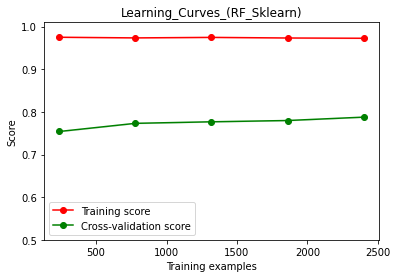

In [19]:
plt.figure()
plt.grid()

title = "Learning_Curves_(RF_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig(PATH+title)
plt.show()

## DT-Regression

In [20]:
MODEL = DecisionTreeRegressor
params = {"criterion": ["mse"]}
NAME = "DT"
PATH = "out/"+NAME+"/"


modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
score_list_DT = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

('criterion',) (['mse'],)
Finished evaluation
R2_score= 0.6099043911099757
Total evaluation time = 0.17s


,criterion,train_time,inference_time,R2_score,RMSE
0,mse,0.01082,0.000594,0.609904,0.400143


('criterion',) (['mse'],)
Finished evaluation
R2_score= 0.6602014624968617
Total evaluation time = 0.17s


,criterion,train_time,inference_time,R2_score,RMSE
0,mse,0.010397,0.000411,0.660201,0.331762


('criterion',) (['mse'],)
Finished evaluation
R2_score= 0.6099043911099757
Total evaluation time = 0.17s
('criterion',) (['mse'],)
Finished evaluation
R2_score= 0.6602014624968617
Total evaluation time = 0.17s
('criterion',) (['mse'],)
Finished evaluation
R2_score= 0.6602014624968617
Total evaluation time = 0.17s


,criterion,train_time,inference_time,R2_score,RMSE
0,mse,0.014474,0.000755,0.660201,0.331762


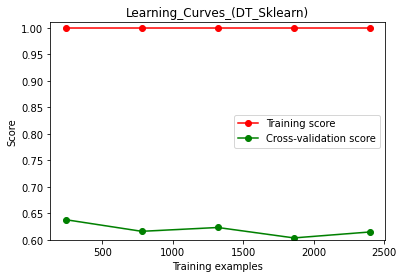

In [21]:
plt.figure()
plt.grid()

title = "Learning_Curves_(DT_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = DecisionTreeRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)
plt.savefig(PATH+title)
plt.show()

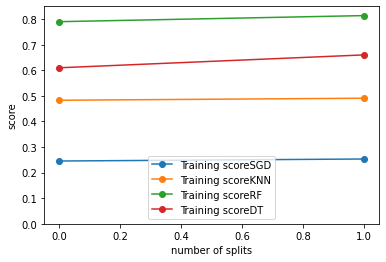

In [22]:
plot_learning_curve_own(score_list_SGD,"SGD", ylim=(0, 0.85))
plot_learning_curve_own(score_list_KNN,"KNN")
plot_learning_curve_own(score_list_RF,"RF")
plot_learning_curve_own(score_list_DT,"DT")
plt.savefig("out/shuffle_vs_score")

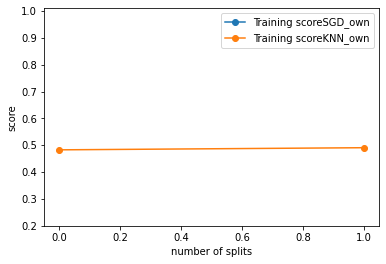

In [23]:
plot_learning_curve_own(score_list_SGD_own,"SGD_own", ylim=(0.2, 1.01))
plot_learning_curve_own(score_list_KNN_own,"KNN_own")
plt.savefig("out/shuffle_own_vs_score")